In [3]:
import gym, os
from itertools import count
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
import matplotlib.pyplot as plt
import numpy as np
%load_ext autoreload
%autoreload 2

# DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
class Actor(nn.Module):
    def __init__(self, state_size, action_size):
        super(Actor, self).__init__()
        self.linear1 = nn.Linear(state_size, 128)
        self.linear3 = nn.Linear(128, action_size)

    def forward(self, state):
        output = F.relu((self.linear1(state)))
        output = self.linear3(output)
        distribution = F.softmax(output, dim=1)
        return distribution


class Critic(nn.Module):
    def __init__(self, state_size):
        super(Critic, self).__init__()
        self.linear1 = nn.Linear(state_size, 128)
        self.linear3 = nn.Linear(128, 1)

    def forward(self, state):
        output = F.relu((self.linear1(state)))
        # output = F.relu(self.linear2(output))
        value = self.linear3(output)
        return value

def pick_action(actor, state):
    state = torch.from_numpy(state).float().unsqueeze(0)
    action_probs = actor(state)
    
    dist = Categorical(action_probs)
    action = dist.sample()

    return action.item(), dist.log_prob(action)

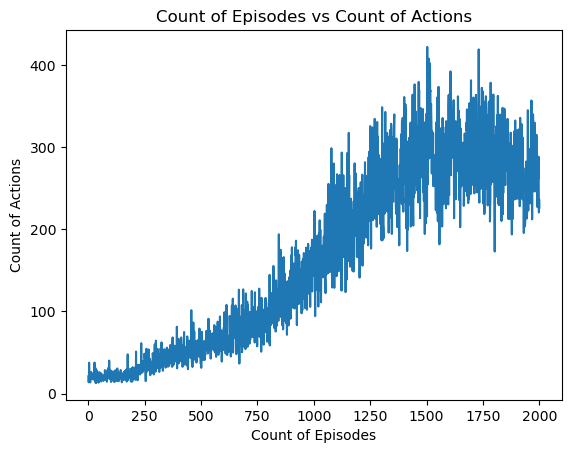

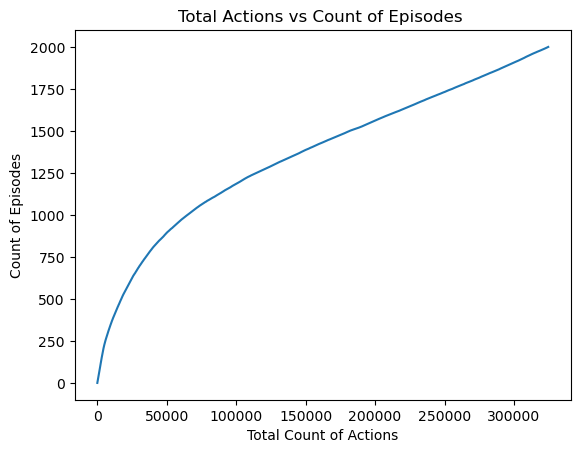

In [33]:
gamma = 0.9
num_episodes = 2000
num_steps = 1000
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# env = gym.make("MountainCar-v0")
env = gym.make('CartPole-v1')
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

count_episode = range(1,num_episodes+1)
count_ca = []
count_tca = []

for k in range(5):
    # env = gym.make("MountainCar-v0")
    env = gym.make('CartPole-v1')
    actor = Actor(state_size=state_size, action_size=action_size)
    critic = Critic(state_size)

    
    count_actions = []
    total_count_actions = []
    total_a = 0

    for episode in range(num_episodes):
        actor_optim = optim.SGD(actor.parameters(),lr=0.001, momentum=0.1)
        critic_optim = optim.SGD(critic.parameters(), lr=0.001, momentum=0.1)
        state = env.reset()
        isTerminal = False
        score = 0
        I = 1
        count_a = 0
        

        while not isTerminal:
            count_a += 1
            
            
            action, log_prob = pick_action(actor, state=state)
            state_tensor = torch.from_numpy(state).float().unsqueeze(0)
            v_curr = critic(state_tensor)
                
            state_prime, reward, isTerminal, info = env.step(action)
            state_prime_tensor = torch.from_numpy(state_prime).float().unsqueeze(0)
            v_next = critic(state_prime_tensor)

            score += reward
           
            
            
            if isTerminal:
                v_next = torch.tensor([0]).float().unsqueeze(0)

            td_target = reward + gamma * v_next
            td_error = reward + gamma*v_next.item()-v_curr.item()
            critic_loss = F.mse_loss(td_target,v_curr)
            actor_loss = -log_prob * td_error
            
            
            # Policy
            actor_optim.zero_grad()
            actor_loss.backward(retain_graph=True)
            actor_optim.step()
            
            # print(critic_loss)
            critic_optim.zero_grad()
            critic_loss.backward()
            critic_optim.step()

            if isTerminal:
                break

            state = state_prime

            # print(f'Actor loss is {actor_loss} and critic loss is {critic_loss}')
            # if state_prime[0] >= 0.5:
            #     break
            # print(state)
        # print(f'This is the count {count_a} and this is the score {score}')
        count_actions.append(count_a)
        total_a += count_a
        total_count_actions.append(total_a)
        
    torch.save(actor, f'actor{k}.pkl')
    torch.save(critic, f'critic{k}.pkl')
    env.close()
    count_ca.append(count_actions)
    count_tca.append(total_count_actions)


avg_ca = np.array(count_ca)
avg_ca = np.average(count_ca, axis=0)
plt.figure()
plt.title('Count of Episodes vs Count of Actions')
plt.xlabel('Count of Episodes')
plt.ylabel('Count of Actions')
plt.plot(count_episode, avg_ca)
plt.savefig('count_actions_ac.jpg')
plt.show()

avg_tca = np.array(count_tca)
avg_tca = np.average(count_tca, axis=0)
plt.figure()
plt.title('Total Actions vs Count of Episodes ')
plt.ylabel('Count of Episodes')
plt.xlabel('Total Count of Actions')
plt.plot(avg_tca, count_episode)
plt.savefig('total_actions_ac.jpg')
plt.show()

In [31]:
np.average(np.array([[1,2,3], [4,5,6],[2,3,4]]),axis=0)

array([2.33333333, 3.33333333, 4.33333333])

In [32]:
7/3

2.3333333333333335

In [24]:
import gym
# env = gym.make('MountainCar-v0')
env.reset()

while not isTerminal:
    action = torch.argmax(actor(state))
    state_prime, reward, isTerminal, info = env.step(action.item())
    state_prime = torch.FloatTensor(state_prime)
    state = state_prime
    # env.step(env.action_space.sample())
    env.render()